# Train your own Phytoplankton Classifier.

`This notebook was developed for Eart119A in Spring25 by Patrick Daniel.`

## Goal

Here we will train two different phytoplankton classifiers, a simple CNN and a then we are going to use __ResNet18__ and train one with Tranfer Learning.

### But First, Make sure you are using a GPU

_If on colab:_  
Training greatly benefits from using "T4 GPU" so got up to the top right corner and click on the carrot. Select __Change Runtime Type__ and __select T4 GPU__.



## Getting Training Data

 This code below will pull the training data from a repo that I setup and unzip it into a directory called "training".

 Open it up and look around, you should see 6 different directories that contain images of phytoplankton.

In [1]:
# prompt: Get a remote .zip file from https://git.ucsc.edu/pcdaniel/eart119a-ML-Lecture/-/blob/5704ab8e2acbe5363004460bdc94960422f8010a/phyto-mini/training.zip
!wget https://git.ucsc.edu/pcdaniel/eart119a-ML-Lecture/-/raw/5704ab8e2acbe5363004460bdc94960422f8010a/phyto-mini/training.zip
!unzip training.zip

--2025-06-10 03:46:16--  https://git.ucsc.edu/pcdaniel/eart119a-ML-Lecture/-/raw/5704ab8e2acbe5363004460bdc94960422f8010a/phyto-mini/training.zip
Resolving git.ucsc.edu (git.ucsc.edu)... 169.233.8.13
Connecting to git.ucsc.edu (git.ucsc.edu)|169.233.8.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67359597 (64M) [application/octet-stream]
Saving to: ‘training.zip.1’

training.zip.1      100%[===================>]  64.24M  39.1MB/s    in 1.6s    

2025-06-10 03:46:20 (39.1 MB/s) - ‘training.zip.1’ saved [67359597/67359597]

Archive:  training.zip
  inflating: __MACOSX/._training     
replace training/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### Examining the Training Data ###

Pytorch can load data pretty efficiently using __Data Loaders__. Before we start that, lets look at some of the images once that have been processed:

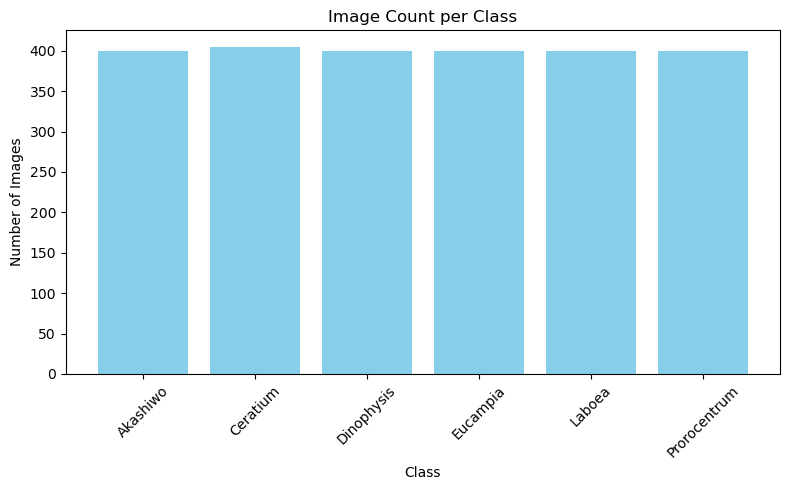

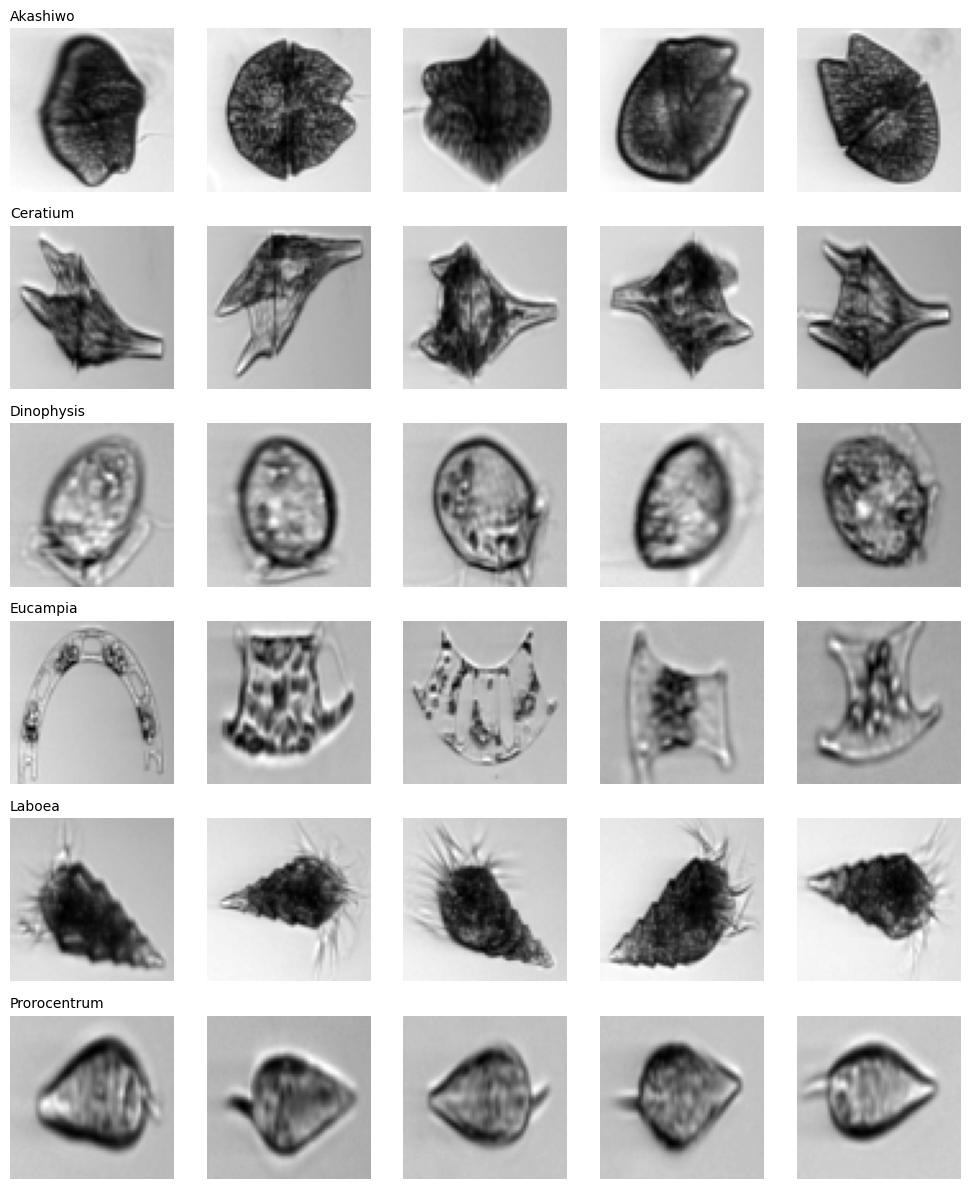

In [38]:
import os
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import numpy as np

# Replace this with your dataset path
data_dir = "training"

# Transform to load images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load dataset
dataset = ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes

# Count images per class
class_counts = {name: 0 for name in class_names}
for _, label in dataset.samples:
    class_name = class_names[label]
    class_counts[class_name] += 1

# Plot histogram
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Image Count per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("class_distribution_histogram.png")
plt.show()

# Create mosaic: 5 images from each class
fig, axs = plt.subplots(len(class_names), 5, figsize=(10, 2 * len(class_names)))
for row, class_name in enumerate(class_names):
    class_indices = [i for i, (_, label) in enumerate(dataset.samples) if dataset.classes[label] == class_name]
    for col, idx in enumerate(class_indices[:5]):
        img, _ = dataset[idx]
        axs[row, col].imshow(img.squeeze(), cmap='gray')
        axs[row, col].axis('off')
        if col == 0:
            axs[row, col].set_title(class_name, loc='left', fontsize=10)
plt.tight_layout()
plt.savefig("class_image_mosaic.png")
plt.show()

## Now lets start the training. ##

Run the cell below to train the "simple" model.


It will go through __10 Epochs__ meaning the model will see all of the data 10 times. We can adjust this as neeeded, if the __Loss__ plateaus early.

The __batch size__ corresponds to how many images we can feed to the model at once. This depends on how much vRAM the GPU has. If you can feed it more, it will train faster.

The __transforms__ are the routines used to prepare the iamges for training. They will be:
1. Converted to greyscale (they actually aready are in greyscale, but we want it as one channel instead of RGB)
2. Resized into a smaller size to train faster (64x64 pxs)
3. Converted into a __Tensor__. This is basically a big matrix, efficient matrix.
4. Finally Images are normalized based on a mean and standard deviations. This value can depend on the data.

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Settings
data_dir = "training"  # Update this path
batch_size = 64
num_epochs = 10
num_classes = 6
learning_rate = 0.001

# Transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,), (0.228,))
])

# Load Dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print(f"Number of images: {len(dataset)}")

Number of images: 2405


## Train/Validation Split ##

We want to reserve some of that data to be used for validating how well the model worked, so we will split it up into __train_set__ and __val_set__ at a ratio of 80:20.

The model will never see the __validation__ set untill we are estimating statistics

In [5]:

# 80/20 Train/Validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)


## Defing the Model Structure ##

We are first going to use a very simple CNN structure.

In [6]:

# Define CNN
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 64 → 32
        x = self.pool(torch.relu(self.conv2(x)))  # 32 → 16
        x = x.view(-1, 16 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Now we want to make the model and ensure that it is running on a __GPU__.

There are some other important parameters here like: `CrossEntropyLoss` which is our loss function and `Adam`, a very efficient stochaistic-gradient method.

In [7]:

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Using device: cuda


## Training ##

The model is now ready to be trained! We are going to loop through each epoch (remember we said earlier that we want to see all of the images 10 times).

During each Epoch we are going to get the __Loss__ value so that we can plot it and see how it changes over training.

__Warning: This step might be a bit slow!__

Epoch 1/10 - Loss: 1.1032
Epoch 2/10 - Loss: 0.3080
Epoch 3/10 - Loss: 0.2442
Epoch 4/10 - Loss: 0.1841
Epoch 5/10 - Loss: 0.1478
Epoch 6/10 - Loss: 0.1146
Epoch 7/10 - Loss: 0.0821
Epoch 8/10 - Loss: 0.0866
Epoch 9/10 - Loss: 0.0793
Epoch 10/10 - Loss: 0.0551


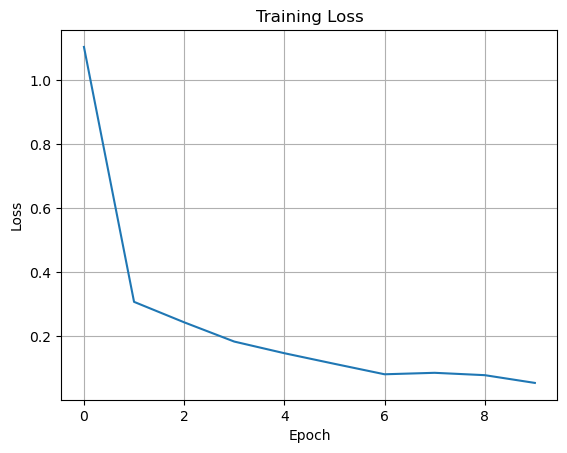

In [8]:

# Training Loop
train_loss_list = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_loss_list.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

# Plot Training Loss
plt.plot(train_loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

## Now Let's Evaluate the Model Performance ##

Remember that we saved 20% of the images for validation.

Let's calculate some of those statistics

Accuracy: 0.960
F1 Score (weighted): 0.960


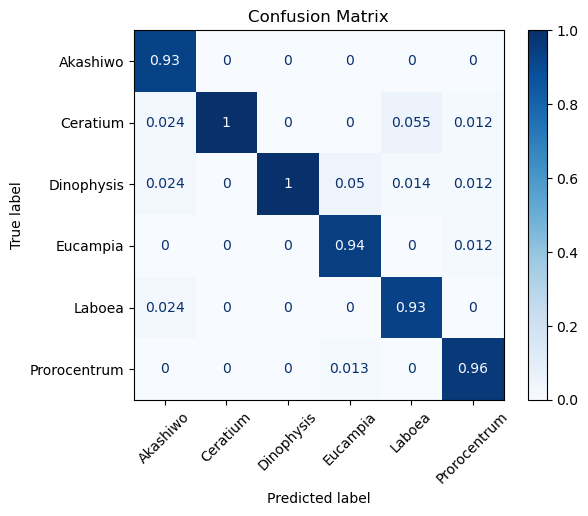

In [9]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds, normalize='pred')

print(f"Accuracy: {acc:.3f}")
print(f"F1 Score (weighted): {f1:.3f}")

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

## Now train a model using the ResNet18 Architecture ##

ResNet 18 now has 18 layers, but it uses some special tricks that make it incredibly efficient.

__We are also going to use the pre-trained model weights__. So the feature extraction should already be pretty good at distinguishing things for us.

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15 - Train Loss: 0.6343 - Val Loss: 3.1855
Validation loss improved. Saving model...
Epoch 2/15 - Train Loss: 0.0671 - Val Loss: 3.5796
Epoch 3/15 - Train Loss: 0.0220 - Val Loss: 1.1420
Validation loss improved. Saving model...
Epoch 4/15 - Train Loss: 0.0097 - Val Loss: 0.2411
Validation loss improved. Saving model...
Epoch 5/15 - Train Loss: 0.0087 - Val Loss: 1.1244
Epoch 6/15 - Train Loss: 0.0040 - Val Loss: 0.5208
Epoch 7/15 - Train Loss: 0.0041 - Val Loss: 0.0607
Validation loss improved. Saving model...
Epoch 8/15 - Train Loss: 0.0020 - Val Loss: 0.0380
Validation loss improved. Saving model...
Epoch 9/15 - Train Loss: 0.0016 - Val Loss: 0.0276
Validation loss improved. Saving model...
Epoch 10/15 - Train Loss: 0.0008 - Val Loss: 0.0202
Validation loss improved. Saving model...
Epoch 11/15 - Train Loss: 0.0016 - Val Loss: 0.0161
Validation loss improved. Saving model...
Epoch 12/15 - Train Loss: 0.0005 - Val Loss: 0.0199
Epoch 13/15 - Train Loss: 0.0012 - Val Loss: 0.01

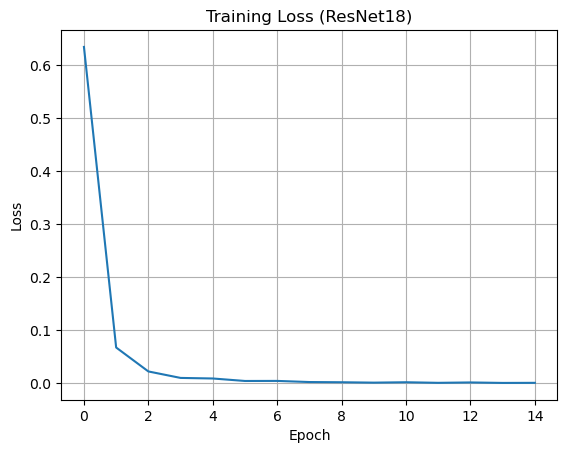

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Settings
data_dir = "training"  # Update this path
batch_size = 450
num_epochs = 15
num_classes = 6
learning_rate = 0.001

best_val_loss = float('inf')
patience = 3
patience_counter = 0
checkpoint_path = "./model/resnet18-6class-best.pth"


# Transforms for ResNet (ImageNet compatible)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.489), (0.225))
])

# Load Dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# 80/20 Train/Validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Load Pretrained ResNet18 and use transfer learning
model = models.resnet18(weights=True)

# Modify first conv layer for grayscale input
# Resnet normally acceptys 3-channel RGB
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify final FC layer for 6 classes (instead of the 1000 used by ImageNet)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append(epoch_train_loss)

    # --- Validation ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    epoch_val_loss = running_val_loss / len(val_loader)
    val_loss_list.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")

    # --- Checkpoint ---
    if epoch_val_loss < best_val_loss:
        print("Validation loss improved. Saving model...")
        best_val_loss = epoch_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss
        }, checkpoint_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


Accuracy: 0.988
F1 Score (weighted): 0.987
Weighted Accuracy: 0.987
              precision    recall  f1-score   support

    Akashiwo       0.99      1.00      0.99        76
    Ceratium       1.00      0.97      0.99        80
  Dinophysis       0.99      0.98      0.98        85
    Eucampia       0.97      0.97      0.97        67
      Laboea       0.99      1.00      0.99        83
Prorocentrum       0.99      1.00      0.99        90

    accuracy                           0.99       481
   macro avg       0.99      0.99      0.99       481
weighted avg       0.99      0.99      0.99       481



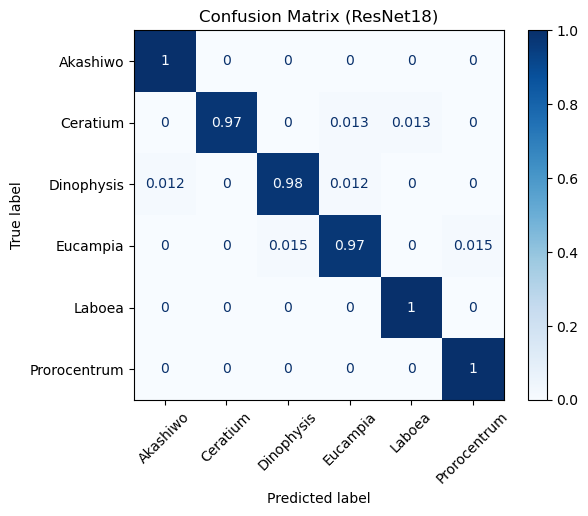

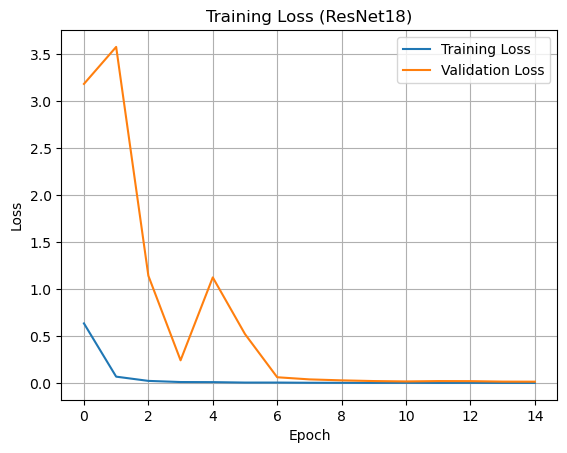

In [40]:

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

cm = confusion_matrix(all_labels, all_preds,normalize="true")

# Calculate per-class accuracy
class_counts = np.sum(cm, axis=1)
correct_preds = np.diag(cm)
per_class_accuracy = correct_preds / class_counts
# Weighted accuracy
weighted_acc = np.sum(per_class_accuracy * (class_counts / np.sum(class_counts)))



print(f"Accuracy: {acc:.3f}")
print(f"F1 Score (weighted): {f1:.3f}")
print(f"Weighted Accuracy: {weighted_acc:.3f}")

# Classification Report
class_names = dataset.classes
class_indices = list(range(len(class_names)))

cr = classification_report(np.array(all_labels), np.array(all_preds),labels=class_indices, target_names=class_names, zero_division=0)
print(cr)
with open("classification_report.txt", "w") as f:
    f.write(cr)

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (ResNet18)")
plt.savefig("ConfusionMatrix_resnet18.png",bbox_inches='tight')
plt.show()

# Plot Training Loss
plt.plot(train_loss_list,label="Training Loss")
plt.plot(val_loss_list,label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (ResNet18)")
plt.legend()
plt.grid(True)
plt.savefig("training_loss.png",bbox_inches='tight')

In [35]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 11173318


In [34]:
# Save path
save_path = "./model/resnet18-6class.pth"

# Get the class-to-index mapping from the dataset
class_to_idx = dataset.class_to_idx

# Create a checkpoint dictionary
checkpoint = {
    'model_state_dict': model.state_dict(),     # weights
    'model_arch': 'resnet18',                   # structure hint
    'num_classes': num_classes,
    'class_to_idx': class_to_idx,
    'input_channels': 1                         # since we modified conv1
}

# Save it
torch.save(checkpoint, save_path)
print(f"Model saved to {save_path}")

Model saved to ./model/resnet18-6class.pth
